### Scorecard

In [1]:
import math
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_colors_from_map(palette='Blues', value=1):
    """ Create colors from a heatmap
    
    Here, we would like to have 7 colors at most
    for easier visualization.
    
    However, the maximum number of crosses is 14. Therefore,
    I divide by 2 to get at most 7 colors.
    
    It should be based on the actual maximum value instead
    of manually setting the number of colors. However, these 
    are the settings I want for my personal visualization. 
    
    """
    value = round(value/2)
    cmap = plt.cm.get_cmap(palette, 7)
    rgb = cmap(value)
    return matplotlib.colors.rgb2hex(rgb)

def count_total_color(row, value):
    """
    # Add number of times a person got a score in a row
    # Thus number of multipliers per game    
    """
    count = 0
    if sum([row.r_2, row.r_3,row.r_4,row.r_5,row.r_6,row.r_7,row.r_8,
          row.r_9,row.r_10,row.r_11,row.r_12,row.r_13]) == value:
        count += 1
    if sum([row.ge_2, row.ge_3,row.ge_4,row.ge_5,row.ge_6,row.ge_7,row.ge_8,
          row.ge_9,row.ge_10,row.ge_11,row.ge_12,row.ge_13]) == value:
        count += 1
    if sum([row.g_2, row.g_3,row.g_4,row.g_5,row.g_6,row.g_7,row.g_8,
          row.g_9,row.g_10,row.g_11,row.g_12,row.g_13]) == value:
        count += 1
    if sum([row.b_2, row.b_3,row.b_4,row.b_5,row.b_6,row.b_7,row.b_8,
          row.b_9,row.b_10,row.b_11,row.b_12,row.b_13]) == value:
        count += 1
    return count

def get_crosses_color(row, color):
    """ Return number of crosses per color
    """
    points = row[[color+'_{}'.format(i) for i in np.arange(2, 14, 1)]].sum()
    return int(points)

def get_points_color(row, color):
    """ Get total points per color depending on the multiplier
    """
    point_multiplier = {i:val for i,val in zip(np.arange(0, 13, 1), 
                                               [0, 1, 3, 6, 10, 15, 21, 28, 36, 45, 55, 66, 78])}
    points = point_multiplier[row[color+'_cross']]
    return points

def total_points(row):
    """ Return total number of points
    """
    points = row['r_points']+row['ge_points']+row['g_points']+row['b_points']-row['mislukt']
    return points

def get_win_lose(row, df):
    """ If you won or lost a match
    """
    other = df.loc[df.ID == row.ID, :]
    other = other.loc[other.Person != row.Person, 'total_points'].values[0]
    if row.total_points > other:
        return "Win"
    else:
        return "Lose"
    
df = pd.read_excel('Qwixx.xlsx').fillna(0)

max_val = df.groupby('Person').sum().drop(['mislukt', 'ID'], 1).values.max()
# min_val = df.groupby('Person').sum().drop(['mislukt', 'ID'], 1).values.min()

# vals is a dict that is used to make lookups easier in the visualization generation
cols = ['r', 'ge', 'g', 'b']
cols_dict = {col: [col+'_'+str(i) for i in np.arange(2, 14, 1)] for col in cols}
vals = {person:{col: list(pd.DataFrame(df.loc[df.Person==person, :].sum()).T[cols_dict[col]].values[0])
                for col in cols} 
        for person in ['Ilse', 'Maarten']}

# Add number of times a person got a score in a row\
# Thus number of multipliers per game
for i in np.arange(1, 13, 1):
    df['mult_{}'.format(i)] = df.apply(lambda row: count_total_color(row, i), 1)

# number of crosses and points per color per game
for i in ['r', 'ge', 'g', 'b']:    
    df['{}_cross'.format(i)] = df.apply(lambda row: get_crosses_color(row, i), 1)
for i in ['r', 'ge', 'g', 'b']:    
    df['{}_points'.format(i)] = df.apply(lambda row: get_points_color(row, i), 1)
    
# Total points
df['total_points'] = df.apply(lambda row: total_points(row), 1)

# Won or lost match
df['win_lose'] = df.apply(lambda row: get_win_lose(row, df), 1)

In [95]:
# Variables
palette = 'Blues' #PuBuGn or #YlGnBu or Blues or #RdYlBu
person = '...'
im = np.array(Image.open('qwixx_new_v2.png'), dtype=np.uint8)

# Create plot and show image
fig,ax = plt.subplots(1)
ax.imshow(im)

# Heatmap
for i in range(11):
    color = get_colors_from_map(palette=palette, value=int(vals[person]['r'][i]))
    p_fancy = FancyBboxPatch((90+(i*130.8),62), 128, 128, 
                             boxstyle="round,pad=0.1, rounding_size=20", 
                             ec='white',fc=color)
    plt.text(180+(i*130), 90, str(i+2), fontsize=14, color='white')    
    ax.add_patch(p_fancy)

    color = get_colors_from_map(palette=palette, value=int(vals[person]['ge'][i]))
    p_fancy = FancyBboxPatch((90+(i*130.8),235), 128, 128, 
                         boxstyle="round,pad=0.1, rounding_size=20", 
                         ec='white',fc=color)
    plt.text(180+(i*130), 260, str(i+2), fontsize=14, color='white')
    ax.add_patch(p_fancy)
    
    color = get_colors_from_map(palette=palette, value=int(vals[person]['g'][i]))
    p_fancy = FancyBboxPatch((90+(i*130.8),408.5), 128, 128, 
                     boxstyle="round,pad=0.1, rounding_size=20", 
                     ec='white',fc=color)
    plt.text(210+(i*130), 435, str(np.arange(12, 1, -1)[i]), fontsize=14, color='white',
            horizontalalignment='right')
    ax.add_patch(p_fancy)
    
    color = get_colors_from_map(palette=palette, value=int(vals[person]['b'][i]))
    p_fancy = FancyBboxPatch((90+(i*130.8),581.5), 128, 128, 
                 boxstyle="round,pad=0.1, rounding_size=20", 
                 ec='white',fc=color)
    plt.text(210+(i*130), 610, str(np.arange(12, 1, -1)[i]), fontsize=14, color='white', 
            horizontalalignment='right')
    ax.add_patch(p_fancy)

# Plot Circle
for i,val in enumerate(['r', 'ge', 'g', 'b']):
    color = get_colors_from_map(palette=palette, value=int(vals[person][val][-1]))
    circle = plt.Circle((1596,125+(i*173.7)), 47, color=color)
    ax.add_artist(circle)
    
# Set total number of crosses
for i in np.arange(1, 13, 1):
    value = df.loc[df.Person==person, 'mult_{}'.format(i)].sum()
    plt.text(232+((i-1)*100), 860, str(value), fontsize=22, color='black', fontweight='bold',
            horizontalalignment='center')

# Set average points for colors
for i, color in enumerate(['r', 'ge', 'g', 'b']):
    val = round(df.loc[df.Person==person, '{}_points'.format(color)].mean(), 1)
    plt.text(258+(i*200), 995, str(val), fontsize=24, color='black', fontweight='bold',
            horizontalalignment='center')

# Set average points for failed
val = round(df.loc[df.Person==person, 'mislukt'.format(color)].mean(), 1)
plt.text(1107, 995, str(val), fontsize=26, color='black', fontweight='bold',
        horizontalalignment='center')

# Set average points total
val = round(df.loc[df.Person==person, 'total_points'.format(color)].mean(), 1)
plt.text(1470, 1015, str(val), fontsize=50, color='black', fontweight='bold',
        horizontalalignment='center')

# Add keys
for i, color in enumerate(['red', 'yellow', 'green', 'blue']):
    im = OffsetImage(plt.imread('{}_key.png'.format(color)), zoom=0.35)
    ab = AnnotationBbox(im, (1594, 123+(i*174)), frameon=False)
    ax.add_artist(ab)

# remove axes for image
plt.axis('off')

# Add Colorbar
cmap = matplotlib.colors.ListedColormap([get_colors_from_map(palette=palette, 
                                                              value=i) 
                                          for i in [0,2,4,6,8,10,12]])
bounds = np.arange(1, 9, 1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# ax2 = fig.add_axes([0.17, .88, .684, .05])
ax2 = fig.add_axes([0.308, .88, .532, .05])
cb = matplotlib.colorbar.ColorbarBase(ax2, cmap, norm=norm, spacing='proportional',
                                     boundaries=bounds, orientation='horizontal', drawedges=True)
cb.dividers.set_color('black')
cb.dividers.set_linewidth(2)

cb_tick_locs = np.arange(0.5, 8, 1)
cb.set_ticks(cb_tick_locs)
cb.set_ticklabels(["{} - {}".format(i, i+1) for i in np.arange(0, 16, 2)])
# cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=12)
rect1 = patches.Rectangle((-.258,0),1.283,1.3,linewidth=0,facecolor='#E3E3E3',
                         zorder=0,clip_on=False)
ax2.add_patch(rect1)
plt.text(-.14, -.25, 'Number of \nCrosses', fontsize=24, color='black', fontweight='bold',
        horizontalalignment='center')

# Minus points
val = df.loc[df.Person==person, 'mislukt'].mean()
for i in range(math.floor(val)):
    p_fancy = FancyBboxPatch((1394+(i*71),815), 52, 64, 
                 boxstyle="round,pad=0.1, rounding_size=15", 
                 ec='none',fc='#343434')
    ax.add_patch(p_fancy)
val = val - math.floor(val)

p_fancy = FancyBboxPatch((1394+((i+1)*71),815), 52*(val), 64, 
         boxstyle="round,pad=0.1, rounding_size=15", 
         ec='none',fc='#343434')
ax.add_patch(p_fancy)

fig.set_size_inches(18.5, 10.5)
plt.show()
# plt.savefig('testing_maarten.png', dpi=600)

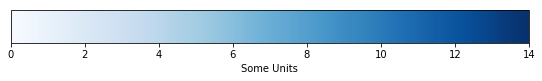

In [252]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=0, vmax=14)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap='Blues',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Some Units')



plt.show()